#### This script prepares a fake database with customer data. The input data comes from [Kaggle Sample Sales Data](https://www.kaggle.com/datasets/kyanyoga/sample-sales-data). 
#### It is licensed under the Creative Commons Attribution-Noncommercial-Share Alike 3.0 Unported License.

In [1]:
from pathlib import Path
import warnings
import pandas as pd
import numpy as np
import re
from datetime import datetime
import sqlite3

import kagglehub
from kagglehub import KaggleDatasetAdapter

/Users/nikitagerman/Desktop/cs50/sales-analytics-dashboard/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PATH_INPUT_DATA = "https://www.kaggle.com/datasets/kyanyoga/sample-sales-data"

PATH_OUT_DB = Path("../dry_cleaning.db")
if PATH_OUT_DB.exists():
    warnings.warn("dry_cleaning.db already exists", UserWarning)

/var/folders/8s/wj7xqgln53j3l4myh47s6q_80000gn/T/ipykernel_64822/3204553739.py:5: UserWarning: dry_cleaning.db already exists
  warnings.warn("dry_cleaning.db already exists", UserWarning)


In [3]:
# Load a DataFrame with data
df: pd.DataFrame = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "kyanyoga/sample-sales-data/versions/1",
    "sales_data_sample.csv",
    pandas_kwargs={"encoding": "windows-1251"}
    )
print(f"Data was successfully loaded from Kannon. Nrows={df.shape[0]}, Ncols={df.shape[1]}")

Data was successfully loaded from Kannon. Nrows=2823, Ncols=25


In [4]:
df.dtypes

ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE               str
STATUS                  str
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE             str
MSRP                  int64
PRODUCTCODE             str
CUSTOMERNAME            str
PHONE                   str
ADDRESSLINE1            str
ADDRESSLINE2            str
CITY                    str
STATE                   str
POSTALCODE              str
COUNTRY                 str
TERRITORY               str
CONTACTLASTNAME         str
CONTACTFIRSTNAME        str
DEALSIZE                str
dtype: object

In [5]:
# Check if SALES = QUANTITYORDERED * PRICEEACH
tol = 1
if (df["SALES"] - (df["QUANTITYORDERED"] * df["PRICEEACH"])).abs().max() > tol:
    print("SALES != QUANTITYORDERED * PRICEEACH")
else:
    print("SALES = QUANTITYORDERED * PRICEEACH")

SALES != QUANTITYORDERED * PRICEEACH


In [6]:
# Filter out the sales which have status = "Shipped"
df = df[df.STATUS == "Shipped"]

In [7]:
# Select only columns which we will use in the follow up analysis
columns_to_select = [
    "QUANTITYORDERED",
    "SALES",
    "ORDERDATE",
    "PRODUCTLINE",
    "CUSTOMERNAME",
    "PHONE",
    "ADDRESSLINE1",
    "COUNTRY",
    "CITY"
]
df = df[columns_to_select]
df.head()

,QUANTITYORDERED,SALES,ORDERDATE,PRODUCTLINE,CUSTOMERNAME,PHONE,ADDRESSLINE1,COUNTRY,CITY
0,30,2871.00,2/24/2003 0:00,Motorcycles,Land of Toys Inc.,2125557818,897 Long Airport Avenue,USA,NYC
1,34,2765.90,5/7/2003 0:00,Motorcycles,Reims Collectables,26.47.1555,59 rue de l'Abbaye,France,Reims
2,41,3884.34,7/1/2003 0:00,Motorcycles,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,France,Paris
3,45,3746.70,8/25/2003 0:00,Motorcycles,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,USA,Pasadena
4,49,5205.27,10/10/2003 0:00,Motorcycles,Corporate Gift Ideas Co.,6505551386,7734 Strong St.,USA,San Francisco


In [8]:
# Rename columns
df.rename({
    "QUANTITYORDERED": "quantity",
    "SALES": "total",
    "ORDERDATE": "order_date",
    "CUSTOMERNAME": "name",
    "PHONE": "phone",
    "ADDRESSLINE1": "address",
    "COUNTRY": "country",
    "CITY": "city"
}, axis=1, inplace=True)
df.head()

,quantity,total,order_date,PRODUCTLINE,name,phone,address,country,city
0,30,2871.00,2/24/2003 0:00,Motorcycles,Land of Toys Inc.,2125557818,897 Long Airport Avenue,USA,NYC
1,34,2765.90,5/7/2003 0:00,Motorcycles,Reims Collectables,26.47.1555,59 rue de l'Abbaye,France,Reims
2,41,3884.34,7/1/2003 0:00,Motorcycles,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,France,Paris
3,45,3746.70,8/25/2003 0:00,Motorcycles,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,USA,Pasadena
4,49,5205.27,10/10/2003 0:00,Motorcycles,Corporate Gift Ideas Co.,6505551386,7734 Strong St.,USA,San Francisco


In [9]:
# Parse order_date
df["order_date"] = df["order_date"].apply(lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M"))

In [10]:
# Remove spaces, dots, +, ), (, - signs in phone.
df["phone"] = df["phone"].apply(lambda x: re.sub("(\\+)|(\\.)|(\\()|(\\))|(\\-)|( )", "", x))

# Check if the replacement was successful by trying .astype(int)
try:
    df["phone"].astype(int)
    print("Phone number contains only int chars")
except:
    print("Some non-int chars are present in phone")

Phone number contains only int chars


In [11]:
# Unique PRODUCTLINE
df["PRODUCTLINE"].value_counts()

PRODUCTLINE
Classic Cars        914
Vintage Cars        557
Motorcycles         324
Trucks and Buses    281
Planes              271
Ships               195
Trains               75
Name: count, dtype: int64

In [12]:
# Replace PRODUCTLINE with more dry-cleaning names-like
df["item"] = df["PRODUCTLINE"].replace({
    "Classic Cars": "shirt",
    "Vintage Cars": "suit",
    "Motorcycles": "jeans",
    "Trucks and Buses": "jacket",
    "Planes": "T-shirt",
    "Ships": "hat",
    "Trains": "backpack"
})
df.drop(["PRODUCTLINE"], axis=1, inplace=True)

In [13]:
# Unique item
df["item"].value_counts()

item
shirt       914
suit        557
jeans       324
jacket      281
T-shirt     271
hat         195
backpack     75
Name: count, dtype: int64

In [14]:
df.head()

,quantity,total,order_date,name,phone,address,country,city,item
0,30,2871.00,2003-02-24,Land of Toys Inc.,2125557818,897 Long Airport Avenue,USA,NYC,jeans
1,34,2765.90,2003-05-07,Reims Collectables,26471555,59 rue de l'Abbaye,France,Reims,jeans
2,41,3884.34,2003-07-01,Lyon Souveniers,33146627555,27 rue du Colonel Pierre Avia,France,Paris,jeans
3,45,3746.70,2003-08-25,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,USA,Pasadena,jeans
4,49,5205.27,2003-10-10,Corporate Gift Ideas Co.,6505551386,7734 Strong St.,USA,San Francisco,jeans


In [15]:
# Create customers table
customers = df.groupby("name").head(1)[["name", "phone", "address", "country", "city"]]

In [ ]:
# Save customer table into db
with sqlite3.connect(PATH_OUT_DB) as conn:
    cursor = conn.cursor()
    cursor.execute(
        """
        CREATE TABLE IF NOT EXISTS customers (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            name TEXT NOT NULL,
            phone INTEGER,
            address TEXT,
            country TEXT,
            city TEXT
        )
        """
    )
    customers.to_sql('customers', conn, if_exists='append', index=False)

In [16]:
# Create items table
items = df[["item"]].rename({"item": "name"}, axis=1).drop_duplicates()

In [18]:
# Save items table into db
with sqlite3.connect(PATH_OUT_DB) as conn:
    cursor = conn.cursor()
    cursor.execute(
        """
        CREATE TABLE IF NOT EXISTS items (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            name TEXT NOT NULL
        )
        """
    )
    items.to_sql('items', conn, if_exists='append', index=False)

In [19]:
# Read created tables back to infer the ids for orders table
with sqlite3.connect(PATH_OUT_DB) as conn:
    # customers
    query = """
        SELECT id AS customer_id, name FROM customers;
    """
    customers = pd.read_sql(query, conn)

    query = """
        SELECT id AS item_id, name AS item FROM items;
    """
    items = pd.read_sql(query, conn)

In [109]:
# create orders table
orders = df[["order_date", "quantity", "total", "name", "item"]]
orders = pd.merge(orders, customers, how="left", on="name", validate="m:1")
orders = pd.merge(orders, items, how="left", on="item", validate="m:1")
orders.drop(["name", "item"], axis=1, inplace=True)
orders.head(10)

,order_date,quantity,total,customer_id,item_id
0,2003-02-24,30,2871.00,1,1
1,2003-05-07,34,2765.90,2,1
2,2003-07-01,41,3884.34,3,1
3,2003-08-25,45,3746.70,4,1
4,2003-10-10,49,5205.27,5,1
5,2003-10-28,36,3479.76,6,1
6,2003-11-11,29,2497.77,7,1
7,2003-11-18,48,5512.32,8,1
8,2003-12-01,22,2168.54,9,1
9,2004-01-15,41,4708.44,10,1


In [110]:
# Modify `total` number so that it evolves according to exponential trend
growth_rate = 1 # Huge annualized growth rate of more than 150%

n_order_date = (
    orders
    .groupby("order_date")["total"]
    .count()
    .reset_index()
    .rename({"total": "n_date"}, axis=1)
)
orders = pd.merge(orders, n_order_date, how="left", on="order_date", validate="m:1")

old_mean_total = orders.total.mean()
mean_n_date = orders.n_date.mean()
min_order_date = orders.order_date.min()

orders["total"] = orders[["order_date", "total", "n_date"]].apply(
    lambda r: (np.exp(growth_rate * (r["order_date"] - min_order_date).days/365)) * r["total"] * mean_n_date / r["n_date"],
    axis=1
)

orders.drop(["n_date"], axis=1, inplace=True)


<Axes: xlabel='order_date'>

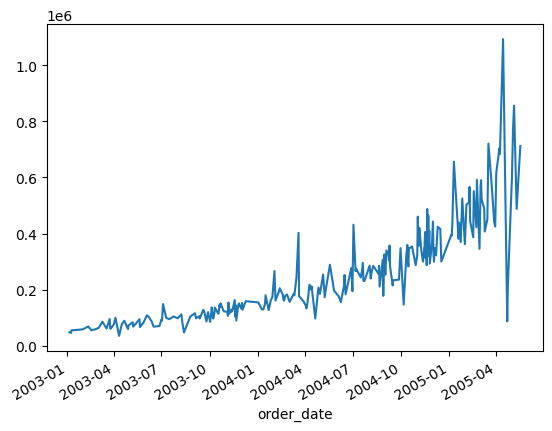

In [111]:
orders.groupby("order_date")['total'].sum().plot()

In [112]:
# create price = total / quantity
orders["price"] = orders["total"] / orders["quantity"]

In [113]:
# save orders table
with sqlite3.connect(PATH_OUT_DB) as conn:
    cursor = conn.cursor()
    cursor.execute(
        """
        CREATE TABLE IF NOT EXISTS orders (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            order_date TEXT NOT NULL,
            quantity INTEGER NOT NULL,
            price REAL NOT NULL,
            total REAL NOT NULL,
            customer_id INTEGER NOT NULL,
            item_id INTEGER NOT NULL,
            FOREIGN KEY (customer_id) REFERENCES customers(id),
            FOREIGN KEY (item_id) REFERENCES items(id)
        )
        """
    )
    orders.to_sql('orders', conn, if_exists='append', index=False)

In [ ]:
# create a schema for users table
with sqlite3.connect(PATH_OUT_DB) as conn:
    cursor = conn.cursor()
    cursor.execute(
        """
        CREATE TABLE IF NOT EXISTS users (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            username TEXT not NULL,
            password_hash TEXT NOT NULL,
            rights TEXT NOT NULL CHECK (rights IN ('admin', 'user'))
        )
        """
    )